In [13]:
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.offline as pyo
import cufflinks as cf
from plotly.offline import init_notebook_mode,plot, iplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score
import os

Reading datasets into Pandas DataFrames

In [3]:
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')

In [5]:
# View the first few rows of each dataset.
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [8]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# Preparation

In [19]:
# Check for missing values in stores.csv
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [20]:
# Check for missing values in train.csv
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [21]:
# Check for missing values in test.csv
test.isnull().sum()

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

In [12]:
# Check for missing values in features.csv
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

Filling in missing values:
* For MarkDown columns: Since these likely represent discounts, filling missing values with 0 might be appropriate, assuming no discount was applied.
* For CPI and Unemployment: Consider filling with the mean or median, as these are continuous variables.

> NOTE:
* Proportion of missing values: If a large portion of a column is missing, imputation might introduce bias.
* Nature of the variable: The meaning of missing values might differ across variables (e.g., 0 for discount vs. unknown for CPI).

In [27]:
features['MarkDown1'].fillna(0, inplace=True)
features['MarkDown2'].fillna(0, inplace=True)
features['MarkDown3'].fillna(0, inplace=True)
features['MarkDown4'].fillna(0, inplace=True)
features['MarkDown5'].fillna(0, inplace=True)
features['CPI'].fillna(features['CPI'].mean(), inplace=True)
features['Unemployment'].fillna(features['Unemployment'].mean(), inplace=True)

In [28]:
# Check if null values are removed
features.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

In [29]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False


Convert Date Column: Convert the 'Date' column in the train and test datasets to datetime objects for easier time-based analysis.

In [31]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

Feature Engineering: Consider creating new features that might be relevant for predicting sales. For example, you could extract month, year, and week of the year from the 'Date' column.

In [34]:
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year
train['WeekOfYear'] = train['Date'].dt.isocalendar().week

test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['WeekOfYear'] = test['Date'].dt.isocalendar().week

Encode Categorical Variables: If you plan to use machine learning models, you'll need to encode categorical variables like 'Type' in the stores dataset. You can use one-hot encoding or label encoding.

In [35]:
# Example: One-hot encoding for 'Type' column
stores = pd.get_dummies(stores, columns=['Type'])

Convert 'Date' columns to datetime format if they are not already

In [41]:
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

Merge Datasets: Merge the stores, train, and features datasets based on common columns like 'Store' to create a single dataset for analysis.

In [42]:
# Merge train and stores datasets on 'Store'
train_merged = pd.merge(train, stores, on='Store')

# Merge the result with features on 'Store' and 'Date'
train_final = pd.merge(train_merged, features, on=['Store', 'Date'])

# Check the result
print(train_final.head())

test_merged = pd.merge(test, stores, on='Store')
test_final = pd.merge(test_merged, features, on=['Store', 'Date'])
print(test_final.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Month  Year  WeekOfYear  \
0      1     1 2010-02-05      24924.50        False      2  2010           5   
1      1     2 2010-02-05      50605.27        False      2  2010           5   
2      1     3 2010-02-05      13740.12        False      2  2010           5   
3      1     4 2010-02-05      39954.04        False      2  2010           5   
4      1     5 2010-02-05      32229.38        False      2  2010           5   

     Size  Type_A  ...  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0  151315    True  ...        42.31       2.572        0.0        0.0   
1  151315    True  ...        42.31       2.572        0.0        0.0   
2  151315    True  ...        42.31       2.572        0.0        0.0   
3  151315    True  ...        42.31       2.572        0.0        0.0   
4  151315    True  ...        42.31       2.572        0.0        0.0   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday_y 

# Visualisation

Visualising weekly sales using a histogram

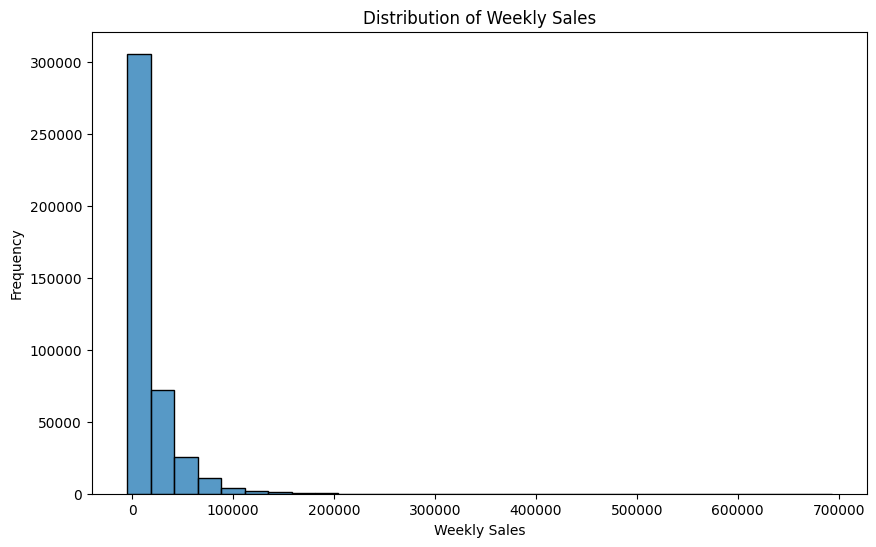

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(train['Weekly_Sales'], bins=30)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

Visualising store types and sizes

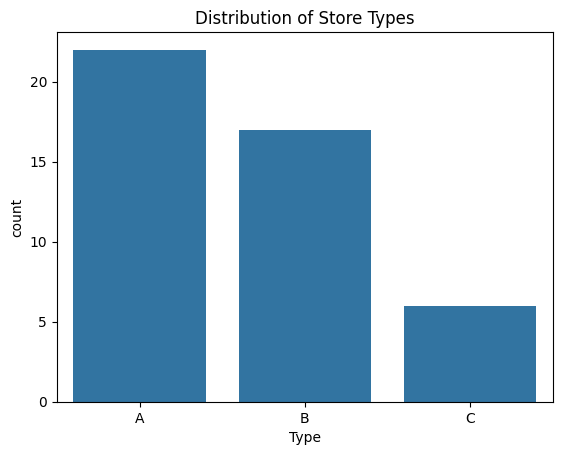

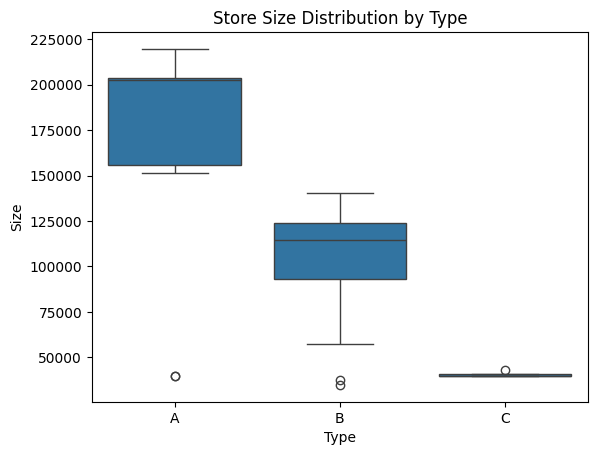

In [15]:
# Bar chart of store types
sns.countplot(x='Type', data=stores)
plt.title('Distribution of Store Types')
plt.show()

# Box plot of store sizes by type
sns.boxplot(x='Type', y='Size', data=stores)
plt.title('Store Size Distribution by Type')
plt.show()

Exploring sales trends

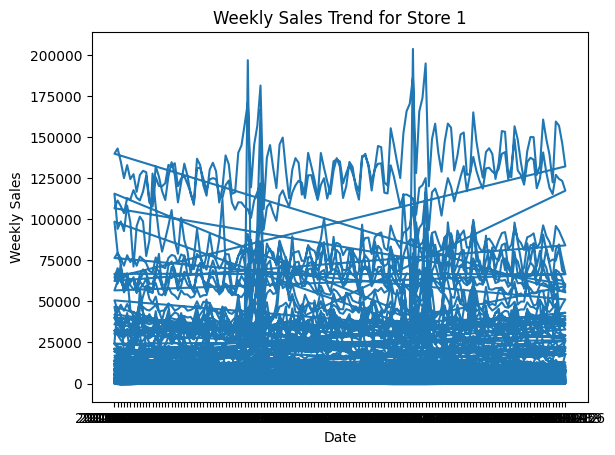

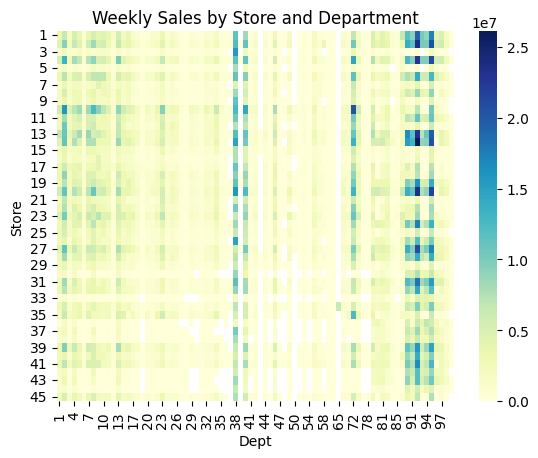

In [16]:
# Time series plot of weekly sales for a specific store
store_1_sales = train[train['Store'] == 1]
plt.plot(store_1_sales['Date'], store_1_sales['Weekly_Sales'])
plt.title('Weekly Sales Trend for Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

# Heatmap of weekly sales by store and department
sales_pivot = train.pivot_table(index='Store', columns='Dept', values='Weekly_Sales', aggfunc='sum')
sns.heatmap(sales_pivot, cmap='YlGnBu')
plt.title('Weekly Sales by Store and Department')
plt.show()

Analysing correlations

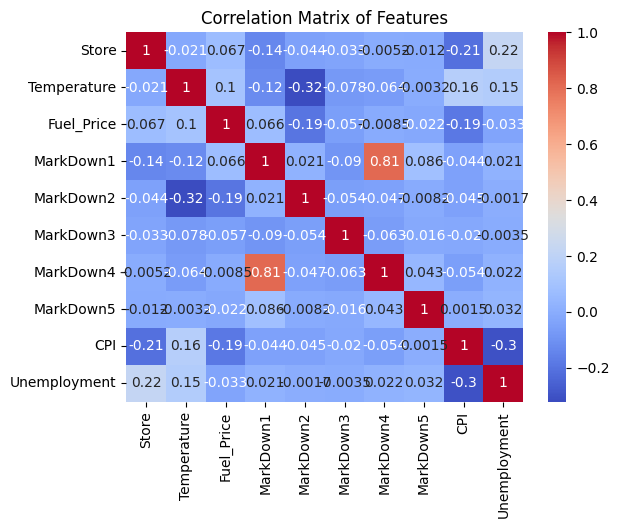

In [18]:
# Select numeric columns only
numeric_features = features.select_dtypes(include=['float', 'int'])

# Calculate correlation matrix
corr_matrix = numeric_features.corr()

# Visualize correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()